In [2]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import nltk
import string
import re
import spacy
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime


nltk.download('punkt_tab')
nltk.download('stopwords')

2025-08-12 02:48:56.128588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754966936.296737      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754966936.354733      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
try:
    db=pd.read_csv('/kaggle/input/portuguese-tweets-for-sentiment-analysis/NoThemeTweets.csv', encoding='utf-8')
except FileNotFoundError:
    print("Arquivo 'NoThemeTweets.csv' não encontrado. Certifique-se de que o arquivo está no diretório correto.")

def converter_datetime(data_str):
    try:
        return datetime.strptime(data_str, "%a %b %d %H:%M:%S %z %Y")
    except Exception as e:
        print(f"Erro ao converter: {data_str} -> {e}")
        return pd.NaT
        
newdb=pd.DataFrame()
newdb['id']=db['id']
newdb['tweet_text'] = db['tweet_text'].str.lower()
newdb['tweet_date']=db['tweet_date'].apply(converter_datetime)
newdb['sentiment']=db['sentiment']
print(newdb.columns)

Index(['id', 'tweet_text', 'tweet_date', 'sentiment'], dtype='object')


In [7]:
print(newdb['tweet_text'].head(10))

0                            @tixaa23 14 para eu ir :)
1        @drexalvarez o meu like eu já dei na época :)
2    eu só queria conseguir comer alguma coisa pra ...
3                                   :d que lindo dia !
4    @primo_resmungao pq da pr jeito!!é uma "oferta...
5    @badwolf_wagner @danievedo eu entendi, mas iss...
6    @chyko661 @g1 [+] carcinoma hepatico (cancer d...
7    aquela mina da limpeza, que tinha um marido co...
8    @narryfools aqui, espero que você melhore logo...
9    @fefocaires se és feliz trabalhando nisso entã...
Name: tweet_text, dtype: object


In [6]:

#1- remoção de caracteres especiais
print('remoção de caracteres especiais')
def remove_mencoes_hashtags(texto):
    if isinstance(texto, str):
        return ' '.join([palavra for palavra in texto.split() if not (palavra.startswith('@') or palavra.startswith('#'))])
    return texto
def remove_links(texto):
    if isinstance(texto, str):
        return re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    return texto
def remove_emojis(texto):
    if isinstance(texto, str):
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
            u"\U0001F680-\U0001F6FF"  # transporte e mapas
            u"\U0001F1E0-\U0001F1FF"  # bandeiras (países)
            u"\U00002700-\U000027BF"  # dingbats
            u"\U000024C2-\U0001F251"  # diversos
            u"\U0001F900-\U0001F9FF"  # emojis suplementares
            u"\U0001FA70-\U0001FAFF"  # objetos adicionais
            u"\U000025A0-\U000025FF"  # formas geométricas
            "]+",
            flags=re.UNICODE
        )
        return emoji_pattern.sub('', texto)
    return texto

def remove_risadas(texto):
    if isinstance(texto, str):
        # Remove sequências de "k", "ha", "he", "hi", "ho", "rs" repetidas
        return re.sub(r'\b(?:k{2,}|(?:ha|he|hi|ho){2,}|(?:rs){1,})\b', '', texto, flags=re.IGNORECASE)
    return texto

def remove_numeros(texto):
    if isinstance(texto, str):
        palavras = texto.split()
        filtradas = [p for p in palavras if not re.search(r'\d', p)]
        return ' '.join(filtradas) if filtradas else None
    return texto

def separar_pontuacao(texto):
    if isinstance(texto, str):
        # separa pontuação colada à palavra
        texto = re.sub(r'([^\w\s])', r' \1 ', texto)
        # remove múltiplos espaços
        texto = re.sub(r'\s{2,}', ' ', texto)
    return texto

def remove_pontuacao(texto):
    if isinstance(texto, str):
        return re.sub(r'[{}—]'.format(re.escape(string.punctuation)), '', texto)
    return texto

newdb['remov_caracteres_especiais'] = newdb['tweet_text'].apply(remove_mencoes_hashtags)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(remove_links)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(remove_emojis)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(remove_risadas)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(remove_numeros)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(separar_pontuacao)
newdb['remov_caracteres_especiais'] = newdb['remov_caracteres_especiais'].apply(remove_pontuacao)

newdb = newdb[~newdb['remov_caracteres_especiais'].isnull()]
newdb = newdb[newdb['remov_caracteres_especiais'].str.strip() != '']

remoção de caracteres especiais


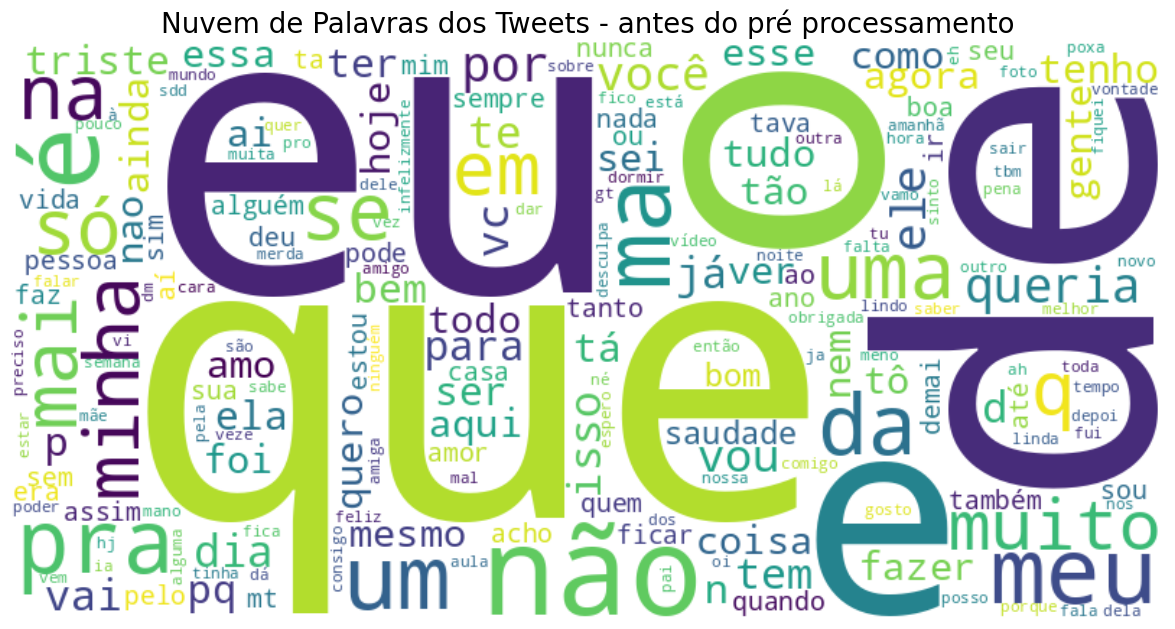

In [7]:
texto_unificado = ' '.join(newdb['remov_caracteres_especiais'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(texto_unificado)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras dos Tweets - antes do pré processamento", fontsize=20)
plt.show()


tokenização
remoção de stopwords
correções e dicionário


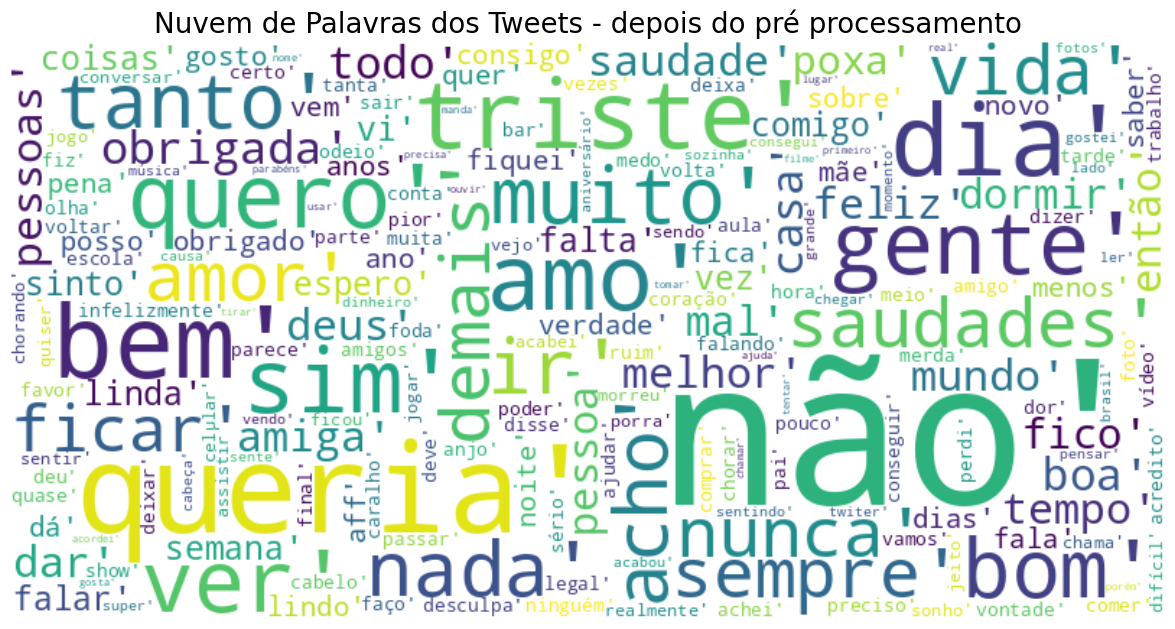

In [ ]:
#2- tokenização
print('tokenização')
newdb['token'] = newdb['remov_caracteres_especiais'].apply(nltk.word_tokenize)


#3- remoção de stopwords
print('remoção de stopwords')

def reduzir_letras_repetidas(tokens):
    excecoes = {'bbb','good','book','bby','tcc','account','scc','sccp','cct','pcc','success','soccer', 'cappuccino','happy','vdd',
                'ddd','daddy','kidding','add','queen','free','reeleito','green','tweets','tweet','teen','pizza','pizzas','pizzaria'}
    resultado = []
    for word in tokens:
        if word in excecoes:
            resultado.append(word)
        else:
            # Reduz letras repetidas a no máximo duas ocorrências
            word = re.sub(r'([^sr])\1+', r'\1', word)
            resultado.append(word)
    return resultado

newdb['token'] = newdb['token'].apply(reduzir_letras_repetidas)

stopwords_informais = set([
    'vc', 'vcs', 'voce', 'você', 'ce', 'cê', 'blz', 'ta', 'tá', 'tô', 'to',
    'eh', 'é', 'foi', 'fui', 'ser', 'sou', 'q', 'pq', 'porque', 'porq', 'porquê',
    'kd', 'cade', 'cadê', 'mano', 'véi', 'vei', 'véio', 'véia', 'cara', 'men', 'fi', 'bro',
    'tio', 'tia', 'tipo', 'ne', 'né', 'num', 'naum', 'oxente', 'oxe', 'eita',
    'ai', 'aí', 'ali', 'aki', 'aqui', 'la', 'lá', 'td', 'nd', 'isso', 'aquilo',
    'daquilo', 'dessa', 'desse', 'desses', 'daí', 'da', 'do', 'de', 'nos', 'em',
    'aquela', 'aquele', 'aquelas', 'aqueles', 'tao', 'tão', 'assim', 'so', 'se',
    'seu', 'sua', 'dele', 'dela', 'meu', 'minha', 'nosso', 'nossa', 'nossos', 'nossas',
    'sei', 'sabia', 'sabe', 'sabem', 'sabemos', 'faz', 'fazer', 'fazendo', 'fez',
    'tava', 'tavam', 'tamos', 'estava', 'estavam', 'estamos', 'vai', 'vão', 'vou',
    'iria', 'podia', 'pode', 'podem', 'tem', 'tenho', 'teve', 'temos', 'tiveram',
    'tiver', 'tivemos', 'ter', 'ok', 'okay', 'beleza',
    'flw', 'falou', 'ate', 'até', 'hj', 'ontem', 'hoje', 'amanha',
    'amanhã', 'logo', 'depois', 'antes', 'agora', 'jae',
    'aliás', 'enfim', 'também','ja', 'já', 'ainda', 'mesmo', 'mesma', 'mesmas',
    'mesmos', 'outro', 'outra', 'outras', 'outros', 'algum', 'alguma',
    'algumas', 'alguns', 'nenhum', 'nenhuma', 'nenhumas', 'nenhuns','nss',
    'tudo', 'toda', 'todas', 'todos', 'qual', 'quais', 'qualquer', 'quaisquer',
    'tb', 'tbm', 'nisso', 'nessa', 'nesse', 'nesses', 'nessas', 'nesta', 'neste',
    'nestes', 'nestas', 'c', 'p', 'd','mai','pá','pa','pra','pr','sdv','ah', 'vixe',
    'ha','cmg','qdo','tmj','btf','mn','desde','tbb','qq','bbk','omg','ae','cntg','qm','xau','hey','yey',
    'dois','uns','oi','cada','onde','isso','algo','coisa','dm','msm','quanto','mim','tou','pois',
    'umas','gt','alguém','agr','duas','viu','disso','ia','oq','qq','ti','tu','sd','pro','oh','sla'
])

stopwords_total = set(nltk.corpus.stopwords.words('portuguese')) | stopwords_informais
stopwords_total = stopwords_total - {'não'}

newdb['stopwords'] = newdb['token'].apply(lambda x: [word for word in x if word not in stopwords_total])


#4- dicionário de palavras e correções
print('correções e dicionário')

mapa_abreviacoes = {
    'n': 'não',
    'nao': 'não',
    'mt': 'muito',
    'mtt': 'muito',
    'mto': 'muito',
    'obg': 'obrigado',
    'obrigad': 'obrigado',
    'dms': 'demais',
    'brigada': 'obrigada',
    'brigado': 'obrigado',
    'af':'aff',
    'vlw': 'valeu',
    'vlws': 'valeu',
    's': 'sim',
    'bb': 'bebê',
    'bjo': 'beijo',
    'bj': 'beijo',
    'bjs': 'beijos',
    'bby':'baby',
    'bbw': 'gata',
    'dsclp':'desculpa',
    'scr':'socorro',
    'cct':'contato',
    'sdds':'saudades',
    'sdd': 'saudade',
    'vdd': 'verdade',
    'fd': 'foda',
    'dmss': 'demais',
    'dms': 'demais',
    'dmssss': 'demais',
    'sds':'saudades',
    'sd':'saudade',
    'miga':'amiga',
    'migo':'amigo',
    'migos':'amigos'
}

def substituir_abreviacoes(palavras):
    if isinstance(palavras, list):
        return [mapa_abreviacoes.get(palavra, palavra) for palavra in palavras]
    return palavras

def remove_letras_sozinhas(tokens):
    return [word for word in tokens if len(word) > 1]

newdb['dicionario'] = newdb['stopwords'].apply(substituir_abreviacoes)
newdb['dicionario'] = newdb['dicionario'].apply(remove_letras_sozinhas)

texto_unificado = ' '.join(newdb['dicionario'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(texto_unificado)

plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de Palavras dos Tweets - depois do pré processamento", fontsize=20)
plt.show()


In [13]:
# 7- embbeddings
print('criando embbeddings')
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
textos = newdb['dicionario'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '').tolist()


embeddings = model.encode(
    textos,
    batch_size=64,              
    show_progress_bar=True,
    convert_to_numpy=True
)

newdb['embeddings'] = list(embeddings)

criando embbeddings


Batches:   0%|          | 0/12277 [00:00<?, ?it/s]

                         id  \
0       1031761728445530112   
1       1031761040462278656   
2       1031760962372689920   
3       1031760948250456066   
4       1031760895985246208   
...                     ...   
785809  1050705141207367680   
785810  1050706655049109504   
785811  1050705846907392005   
785812  1050705490232127489   
785813  1050704920922521601   

                                               tweet_text  \
0                               @tixaa23 14 para eu ir :)   
1           @drexalvarez o meu like eu já dei na época :)   
2       eu só queria conseguir comer alguma coisa pra ...   
3                                      :d que lindo dia !   
4       @primo_resmungao pq da pr jeito!!é uma "oferta...   
...                                                   ...   
785809                       acordar 8 horas é tão bom :)   
785810  @mayckcunha olá, mayck. você já é cliente clar...   
785811  opa tava na merda mm e fiquei logo mais feliz ...   
785812         @a

In [18]:
import json
newdb['embeddings'] = newdb['embeddings'].apply(lambda x: json.dumps(x.tolist()))
print(newdb)


print(type(newdb['embeddings'][0]))
newdb.to_csv('newdb.csv', index=False)
print('fim')

                         id  \
0       1031761728445530112   
1       1031761040462278656   
2       1031760962372689920   
3       1031760948250456066   
4       1031760895985246208   
...                     ...   
785809  1050705141207367680   
785810  1050706655049109504   
785811  1050705846907392005   
785812  1050705490232127489   
785813  1050704920922521601   

                                               tweet_text  \
0                               @tixaa23 14 para eu ir :)   
1           @drexalvarez o meu like eu já dei na época :)   
2       eu só queria conseguir comer alguma coisa pra ...   
3                                      :d que lindo dia !   
4       @primo_resmungao pq da pr jeito!!é uma "oferta...   
...                                                   ...   
785809                       acordar 8 horas é tão bom :)   
785810  @mayckcunha olá, mayck. você já é cliente clar...   
785811  opa tava na merda mm e fiquei logo mais feliz ...   
785812         @a

In [19]:
from IPython.display import FileLink

FileLink('newdb.csv')

/kaggle/working/newdb.csv